In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import scipy
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from matplotlib.figure import Figure
import package_outlier as po
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.stats import pearsonr
import itertools
from sklearn.metrics import roc_auc_score, r2_score
import copy

### Table of contents
- [Volume-Features](#Volume-Features)
    * [Outlier analysis](#Outlier-analysis)
    * [U Test with volumetric features](#U-Test-with-volumetric-features)
    * [Correlation analysis](#Correlation-analysis)
- [Pyradiomics 3d features](#Pyradiomics-3d-features)
    * [Pyrads Outlier analysis](#Pyrads-Outlier-analysis)
    * [Pyrads U test](#Pyrads-U-test)
    * [Pyrads Correlation analysis](#Pyrads-Correlation-analysis)
- [3D Fractal features](#3D-Fractal-features)
    * [Outlier test with 3d fractal features](#Outlier-test-with-3d-fractal-features)
    * [U test with 3d fractal features](#U-test-with-3d-fractal-features)
    * [Correlation analysis with fractal features](#Correlation-analysis-with-fractal-features)
- [CCIPD morphology features](#CCIPD-morphology-features)
    * [CCIPD morphology outliers](#CCIPD-morphology-outliers)
    * [U test with morphology features](#U-test-with-morphology-features)
    * [Correlation analysis with morphology features](#Correlation-analysis-with-morphology-features)
- [Multivariate Analysis](#Multivariate-Analysis)
- [Appendix](#Appendix)
    * [Hierarchical-clustering](#Hierarchical-clustering)

### Volume Features

These include left ventricle (LV) volume, myocardium (LVMC) volume, LV ejection fraction, LV and LVMC mean volumes and standard deviation, etc.

In [2]:
csv_path = os.getcwd()
csv_path

'/Users/saurabh/Desktop/HeartProjects/Exhalted/Params/Code_EXH/unexplained_dyspnea'

In [3]:
# Reading volume csv file
vol_df = pd.read_csv('../vol.csv')
vol_df.drop(columns='Unnamed: 0',inplace=True);
vol_df.head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,100B,2250.174975,14.478556,122988.1875,139436.2500,148709.4375,118114.6875,0,0.205735,2168.140010,20.616114,164954.4375,196361.4375,31407.0000,0.159945
1,101B,3389.251079,10.381979,136187.2500,123462.0000,136187.2500,96996.1875,1,0.287773,9517.657049,2.837491,39867.9375,133344.3750,93476.4375,0.701015
2,103,3343.955006,14.820243,175513.6875,144242.0625,175513.6875,144242.0625,1,0.178172,10586.318292,4.654657,104983.3125,203333.2500,98349.9375,0.483688
3,105B,2464.666301,20.048423,156019.6875,153582.9375,176055.1875,148777.1250,0,0.154940,10604.243561,5.340548,123597.3750,226617.7500,103020.3750,0.454600
4,109,2522.159368,18.556770,111413.6250,126507.9375,135239.6250,111413.6250,0,0.176176,15817.902632,2.284888,42440.0625,153447.5625,111007.5000,0.723423


In [4]:
vol_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lvmc_std,57.0,1780.388646,965.513941,628.804706,1153.427697,1576.147548,2147.494534,5227.582422
lvmc_snr,57.0,23.673666,9.338710,6.836636,16.490328,22.998410,29.353887,51.752073
lvmc_vol_es,57.0,119445.798885,34100.139328,66739.875000,99432.937500,111481.312500,136187.250000,245279.123421
lvmc_vol_ed,57.0,116725.553853,26379.545589,65995.312500,101531.250000,112293.562500,131003.510365,200697.419636
lvmc_vol_max,57.0,127558.325442,32738.120539,71816.437500,109586.062500,122446.687500,143159.062500,249944.650562
lvmc_vol_min,57.0,108747.613617,27844.554100,59294.250000,91613.147363,106018.453125,128538.562500,200697.419636
lvmc_vol_es_equal_max,57.0,0.192982,0.398147,0.000000,0.000000,0.000000,0.000000,1.000000
lvmc_vol_max_minus_min,57.0,0.146202,0.055944,0.051396,0.107206,0.135528,0.180286,0.319470
lv_std,57.0,8723.386003,3067.369561,1293.227392,7026.437692,9064.454540,10604.243561,15817.902632
lv_snr,57.0,4.626109,3.411217,2.119069,3.227912,3.573549,4.431670,20.616114


In [5]:
# Extracting numerical features for scaling
vol_columns = vol_df.columns
numerical_columns = vol_columns.drop(['patient_id','lvmc_vol_es_equal_max']).values

In [6]:
vol_df.shape

(57, 15)

In [7]:
# Min-max scaling
vol_df_scaled = vol_df.copy(deep=True)
vol_df_scaled[numerical_columns] = scaler.fit_transform(vol_df[numerical_columns])

#### Outlier analysis

Let's look at the outliers. The purpose of doing outlier analysis is to go back and check the raw images and do appropriate corrections on the segmentations if required. Low ejection fraction cases (LVEF < 40%) can be excluded from further analysis since it is a known cause of dyspnea. We looked at the segmentations of the anomalies and found that no further corrections were required.   

In [8]:
def outlier_func(df, numerical_columns, num_ouliers_min):
    '''
    Finds features with outliers
    '''
    outlier_features = []
    for feature in numerical_columns:
        outliers = po.ModifiedZscoreOutlier(df[feature].values)
        num_outliers = len(outliers)
        if num_outliers > num_ouliers_min:
            outlier_features.append(feature)
    return outlier_features

In [9]:
# Finding features with more than 3 outliers
outlier_features = outlier_func(vol_df, numerical_columns, 3)
outlier_features

['lv_snr', 'ejection_fraction']

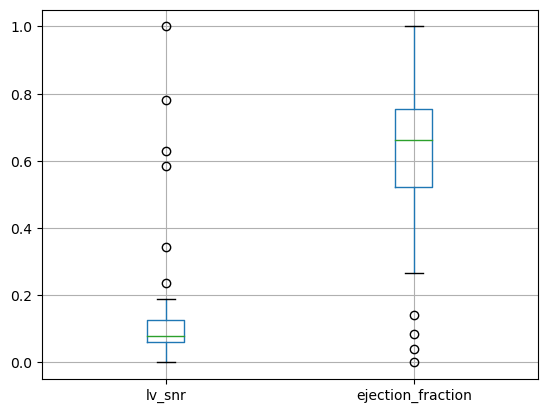

In [11]:
# looking at box plots of outliers
vol_df_scaled.boxplot(column = outlier_features[:]);

In [12]:
# A quick look at the patients with low LVEF
feature = 'ejection_fraction'
vol_df[vol_df[feature] < 0.4].sort_values(by=[feature],ascending=True)

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,100B,2250.174975,14.478556,122988.187500,139436.250000,148709.437500,118114.687500,0,0.205735,2168.140010,20.616114,164954.437500,196361.437500,31407.000000,0.159945
50,188,1153.427697,51.752073,138101.296538,131003.510365,138101.296538,131003.510365,1,0.051396,5913.262444,12.932917,148442.441956,182004.159358,33561.717402,0.184401
7,114,1034.658434,17.811026,85760.062500,100583.625000,100583.625000,82308.000000,0,0.181696,1293.227392,16.560371,92190.375000,117302.437500,25112.062500,0.214080
10,123,632.677214,35.794174,104794.921875,103072.265625,112374.609375,99684.375000,0,0.112928,1969.364777,13.761918,102096.093750,136032.421875,33936.328125,0.249472
8,119,1790.748163,21.044772,137337.937500,135984.187500,155748.937500,133547.437500,0,0.142547,3033.372628,8.487487,78179.062500,116693.250000,38514.187500,0.330046
5,111,1603.417244,15.159323,117975.000000,121875.000000,130275.000000,106575.000000,0,0.181923,3565.792521,6.507337,88800.000000,142875.000000,54075.000000,0.378478


The segmentations of the above patients look fine. Let's drop these patients from the study.

In [13]:
# Dropping patients with LVEF < 40%
low_lv_ef = vol_df[vol_df['ejection_fraction'] < 0.4].patient_id.values
print('Patients with low LVEF \n', low_lv_ef)
vol_df = vol_df[~vol_df['patient_id'].isin(low_lv_ef)]
vol_df.shape

Patients with low LVEF 
 ['100B' '111' '114' '119' '123' '188']


(51, 15)

In [14]:
# Adding percent predicted PkVO2 values to the volume dataframe
cpet_file = '../ExerciseMRIEvaluatio_DATA_LABELS_2021-03-16_1304.xlsx'
cpet_data = pd.read_excel(cpet_file)
cpet_data.dropna(subset=['VO2 (MAX):'],inplace=True)
cpet_data.dropna(subset=['VO2 %Predicted '],inplace=True)
cpet_data.shape

(67, 662)

In [15]:
# Adding new categorical column 'dyspnea'. Patients are separated into 2 groups with  
# percent predicted PkVO2 above or below 79.7
cutoff_pkvo2 = 79.7
cpet_data.loc[cpet_data['VO2 %Predicted '] < cutoff_pkvo2, 'dyspnea'] = int(1)
cpet_data.loc[cpet_data['VO2 %Predicted '] >= cutoff_pkvo2, 'dyspnea'] = int(0)

In [16]:
# looking at class distribution
print(f'low PkVO2, n =', Counter(cpet_data['dyspnea'])[1.0])
print(f'high PkVO2, n =', Counter(cpet_data['dyspnea'])[0.0])

low PkVO2, n = 42
high PkVO2, n = 25


#### U Test with volumetric features

Performing Mann Whitney U test to find features that separate the 2 groups of high and low percent predicted PkVO<sub>2</sub> with statistical significance.

In [17]:
def u_test_func(df, numerical_columns):
    '''
    Performs Mann Whitney U test
    '''
    num_rows = df.shape[0]
    u_test_features = []

    for feature in numerical_columns:
        dyspnea_arr = []
        normal_arr = []

        for n in range(num_rows):
            arr = df.iloc[n][feature]
            pid = df.iloc[n]['patient_id']
            num_pid = int(pid[0:3])
            cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
            condition = cpet_record['dyspnea']
            if condition.values[0] == 1.:
                dyspnea_arr.append(arr)
            else:
                normal_arr.append(arr)
        res = scipy.stats.mannwhitneyu(dyspnea_arr,normal_arr)
        u_test_features.append((feature,round(res.pvalue,3)))    
    return u_test_features, dyspnea_arr, normal_arr

In [18]:
# taking a look at u test p-values
u_test_vol_features, _, _ = u_test_func(vol_df, numerical_columns)
print('(feature, p-value)')
sorted(u_test_vol_features, key = lambda x: x[1])

(feature, p-value)


[('lvmc_vol_ed', 0.048),
 ('lv_std', 0.055),
 ('lvmc_vol_min', 0.103),
 ('lv_vol_ed', 0.109),
 ('lvmc_vol_max', 0.118),
 ('stroke_volume', 0.12),
 ('lvmc_vol_es', 0.199),
 ('lv_vol_es', 0.289),
 ('lvmc_std', 0.349),
 ('lvmc_vol_max_minus_min', 0.664),
 ('ejection_fraction', 0.692),
 ('lv_snr', 0.839),
 ('lvmc_snr', 0.992)]

In [19]:
# extracting features with low p-values for PkVO2 prediction
significant_feat = [ent for ent in u_test_vol_features if ent[1] <= 0.055]
print('significant features: (feature name, p-value)\n', [(ent[0], ent[1]) for ent in significant_feat])

significant features: (feature name, p-value)
 [('lvmc_vol_ed', 0.048), ('lv_std', 0.055)]


In [20]:
# saving important features
important_features = []
important_features.extend([feat[0] for feat in significant_feat])
important_features

['lvmc_vol_ed', 'lv_std']

In [21]:
# looking at the multi-collinearity between features
significant_features = [feat[0] for feat in significant_feat]
X = vol_df_scaled[significant_features].assign(const=1)
vif_values = [vif(X.values, i) for i in range(len(significant_features))]
vif_feat_vals = {significant_features[ind]: vals for ind,vals in enumerate(vif_values)}
vif_feat_vals = sorted(vif_feat_vals.items(), key = lambda item: item[1], reverse = True)
print('VIF values: (feature, value)\n')
[print(ent[0], round(ent[1],3)) for ent in vif_feat_vals];

VIF values: (feature, value)

lvmc_vol_ed 1.089
lv_std 1.089


In [29]:
def box_plot_func(title1, title2, df, feature1, feature2, y1, y2):
    '''
    Box plot to look at how well the 2 groups are separated for each feature
    '''
    fig = Figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title1,fontsize = 14)
    ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
    u_test_vals, dyspnea_arr, normal_arr = u_test_func(df, [feature1])
    ax.boxplot([dyspnea_arr, normal_arr])
    ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
    ax.text(1.2,y1,f'p = {round(u_test_vals[0][1],2)}',fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(title2,fontsize = 14)
    ax.set_xlabel('Measured PkVO$_{2}$ as percentage of predicted PkVO$_{2}$',fontsize=14)
    u_test_vals, dyspnea_arr, normal_arr = u_test_func(df, [feature2])
    ax.boxplot([dyspnea_arr, normal_arr])
    print('patients with low pp PkVO2: ', len(dyspnea_arr), '\npatients with high pp PkVO2: ',len(normal_arr))
    ax.set_xticklabels(labels=['Below 80%','Above 80%'],fontsize=14)
    ax.text(1.2,y2,f'p = {round(u_test_vals[0][1],2)}',fontsize=14)

    return fig

patients with low pp PkVO2:  31 
patients with high pp PkVO2:  20


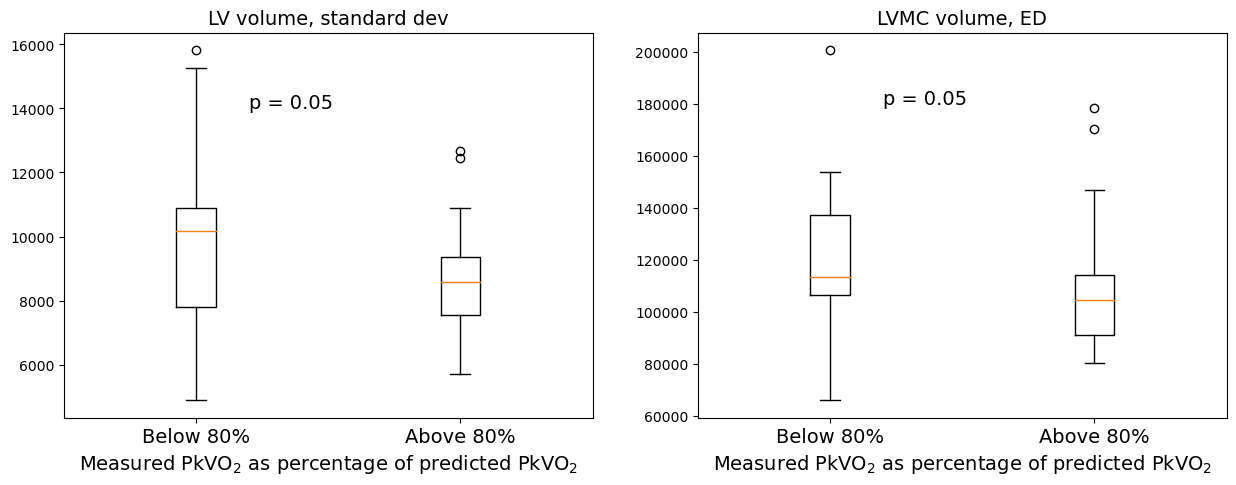

In [29]:
box_plot_func('LV volume, standard dev', 'LVMC volume, ED',  vol_df, 'lv_std', 'lvmc_vol_ed', 14000, 180000)

#### Correlation analysis

Looking at the correlation ($R$<sup>2</sup>) between features and PkVO<sub>2</sub> values.

In [22]:
# adding column 'pkvo2' containing pkvo2 values 
pids = vol_df.patient_id.values
pkvo2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
vol_df['pkvo2'] = pkvo2_vals

In [23]:
# looking at features with reasonable correlation with PkVO2 
response = pkvo2_vals
predictors = numerical_columns
r2_vals = []
for predictor in predictors:
    pearson_val = pearsonr(vol_df[predictor],response)
    r2_vals.append((predictor, round(pearson_val[0]**2,3), "{:.2e}".format(pearson_val[1])))
print('significant features: \n(feature name, R^2, p-value)\n')
significant_feat = [ent for ent in sorted(r2_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1]
significant_feat

significant features: 
(feature name, R^2, p-value)



[('lvmc_vol_min', 0.279, '6.76e-05'),
 ('lv_vol_es', 0.263, '1.20e-04'),
 ('lvmc_vol_ed', 0.251, '1.80e-04'),
 ('lv_vol_ed', 0.229, '3.76e-04'),
 ('lvmc_vol_es', 0.224, '4.57e-04'),
 ('lvmc_vol_max', 0.21, '7.10e-04'),
 ('lv_snr', 0.134, '8.34e-03'),
 ('ejection_fraction', 0.11, '1.76e-02')]

In [25]:
# saving important features for pkvo2 prediction
significant_features = [feat[0] for feat in significant_feat]
important_features.extend(significant_features)
important_features = list(set(important_features))
important_features

['lvmc_vol_max',
 'lv_std',
 'lvmc_vol_ed',
 'ejection_fraction',
 'lvmc_vol_es',
 'lv_snr',
 'lv_vol_ed',
 'lv_vol_es',
 'lvmc_vol_min']

### Pyradiomics 3d features

Analysing shape features extracted from [pyradiomics](https://pyradiomics.readthedocs.io/en/latest/) package.

In [26]:
# reading pyradiomics 3d features
pyrads_3d_df = pd.read_csv('../pyrads_3d.csv')
pyrads_3d_df.drop(columns='Unnamed: 0',inplace=True);
pyrads_3d_df.tail()

,min_original_shape_Elongation,min_original_shape_Flatness,min_original_shape_LeastAxisLength,min_original_shape_MajorAxisLength,min_original_shape_Maximum2DDiameterColumn,min_original_shape_Maximum2DDiameterRow,min_original_shape_Maximum2DDiameterSlice,min_original_shape_Maximum3DDiameter,min_original_shape_MeshVolume,min_original_shape_MinorAxisLength,...,ed_val_original_shape_Maximum2DDiameterSlice,ed_val_original_shape_Maximum3DDiameter,ed_val_original_shape_MeshVolume,ed_val_original_shape_MinorAxisLength,ed_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,ed_val_original_shape_SurfaceVolumeRatio,ed_val_original_shape_VoxelVolume,ed_val_original_shape_AxisRatios,patient_id
52,0.405778,0.387128,34.085171,79.586113,85.955235,93.882268,42.085298,94.165008,57676.083911,35.819611,...,59.041115,120.465067,150684.231441,49.004307,0.704417,19440.135711,0.129012,151888.828014,2.087969,191
53,0.523913,0.490166,38.273509,66.514456,78.656072,77.147597,48.961878,80.087262,65247.143647,39.874683,...,65.522074,95.397728,156462.705306,56.101760,0.781266,17973.208384,0.114872,157608.457213,1.477856,194
54,0.464509,0.440370,38.760831,76.505190,87.791303,87.791303,50.055578,89.849016,79827.368753,41.451489,...,63.671740,115.104661,184157.062555,52.830766,0.763185,20510.673146,0.111376,185185.538802,1.904188,199
55,0.402376,0.373181,36.493419,88.393961,91.570792,88.919595,45.096467,93.046752,68502.499455,37.164443,...,67.840914,119.300873,235389.800936,59.465704,0.713337,25845.288920,0.109798,236665.842547,1.870038,200
56,0.337322,0.315769,32.697454,101.394964,110.193083,110.974380,45.096467,111.303277,68703.542469,35.056133,...,63.906164,127.374804,188254.352416,54.811827,0.670840,23678.918509,0.125782,189532.055539,1.982617,201


In [26]:
pyrads_3d_df.describe().T

,count,mean,std,min,25%,50%,75%,max
min_original_shape_Elongation,57.0,0.487112,0.063486,0.337322,0.453733,0.495134,0.535261,0.599829
min_original_shape_Flatness,57.0,0.435952,0.056442,0.315769,0.399395,0.440370,0.489693,0.533986
min_original_shape_LeastAxisLength,57.0,34.939911,5.279522,23.784889,31.718557,34.641259,38.210702,49.817307
min_original_shape_MajorAxisLength,57.0,74.822626,10.605917,51.937018,66.514456,73.629509,82.730094,101.394964
min_original_shape_Maximum2DDiameterColumn,57.0,81.453770,10.442657,62.936476,75.815978,79.306762,88.131216,110.193083
...,...,...,...,...,...,...,...,...
ed_val_original_shape_Sphericity,57.0,0.748044,0.034444,0.663028,0.726819,0.753739,0.773154,0.806397
ed_val_original_shape_SurfaceArea,57.0,18135.284948,3029.364175,12633.063217,15921.523883,17507.641426,20510.673146,25845.288920
ed_val_original_shape_SurfaceVolumeRatio,57.0,0.123576,0.011447,0.105672,0.115091,0.122124,0.129177,0.157789
ed_val_original_shape_VoxelVolume,57.0,150759.230629,34819.526784,81428.062500,128132.437500,146340.375000,175919.812500,236665.842547


In [27]:
# dropping patients with low LVEF
pyrads_3d_df = pyrads_3d_df[~pyrads_3d_df['patient_id'].isin(low_lv_ef)]
pyrads_3d_df.shape

(51, 121)

In [28]:
# extracting numerical columns for scaling
pyrads_3d_columns = pyrads_3d_df.columns
numerical_columns = pyrads_3d_columns.drop(['patient_id']).values

In [29]:
# looking at features with more than 4 outliers
outlier_features = outlier_func(pyrads_3d_df, numerical_columns, 4)
outlier_features

['snr_original_shape_MajorAxisLength',
 'snr_original_shape_Maximum2DDiameterRow',
 'snr_original_shape_Sphericity']

In [30]:
# min-max scaling
pyrads_3d_df_scaled = pyrads_3d_df.copy(deep=True)
pyrads_3d_df_scaled[numerical_columns] = scaler.fit_transform(pyrads_3d_df[numerical_columns])

#### Pyrads Outlier analysis

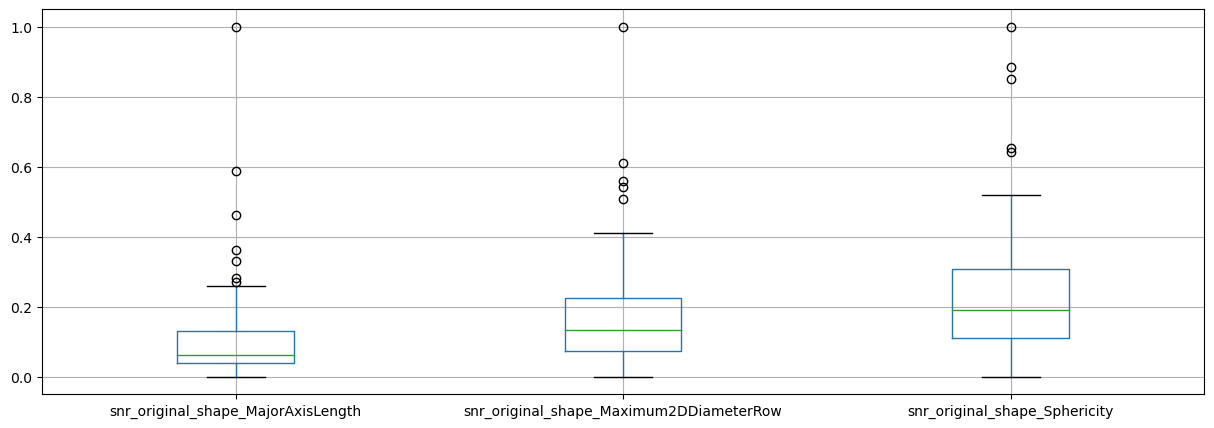

In [31]:
# box plot of features with outliers
pyrads_3d_df_scaled.boxplot(column = outlier_features, figsize = (15,5));

In [32]:
# looking at outliers for 'snr_original_shape_MajorAxisLength'
feature=outlier_features[0]
pyrads_3d_df.sort_values(by=[feature], ascending=False)[['patient_id',feature]].head()

,patient_id,snr_original_shape_MajorAxisLength
31,158,131.295835
15,132,80.157937
13,129,64.545269
22,143,52.175064
2,103,48.235075


In [33]:
# looking at outliers for 'snr_original_shape_Maximum2DDiameterRow'
feature=outlier_features[1]
pyrads_3d_df.sort_values(by=[feature], ascending=False)[['patient_id',feature]].head()

,patient_id,snr_original_shape_Maximum2DDiameterRow
31,158,63.380602
15,132,41.551897
35,162,38.616912
18,135,37.597177
37,167,35.692719


Patients with highest 'snr_original_shape_MajorAxisLength' and 'snr_original_shape_Maximum2DDiameterRow' are major outliers. The segmentations however didn't require any further correction. 

#### Pyrads U test

In [34]:
# performing u test with 3d pyradiomics features
u_test_pyrads_3d_features, _, _ = u_test_func(pyrads_3d_df, numerical_columns)

In [35]:
# looking at features with low p-values
significant_feat = [ent for ent in u_test_pyrads_3d_features if ent[1] <= 0.055]
print('significant features: (feature name, p-value)')
significant_feat = [(ent[0], ent[1]) for ent in sorted(significant_feat, key = lambda x: x[1])]
significant_feat

significant features: (feature name, p-value)


[('max_original_shape_SurfaceArea', 0.03),
 ('ed_val_original_shape_SurfaceArea', 0.036),
 ('mean_original_shape_SurfaceArea', 0.04),
 ('median_original_shape_Sphericity', 0.042),
 ('es_val_original_shape_Maximum2DDiameterSlice', 0.051),
 ('mean_original_shape_Sphericity', 0.053),
 ('min_original_shape_Maximum2DDiameterSlice', 0.055),
 ('max_original_shape_LeastAxisLength', 0.055),
 ('median_original_shape_SurfaceArea', 0.055),
 ('std_dev_original_shape_MeshVolume', 0.055),
 ('std_dev_original_shape_VoxelVolume', 0.055)]

In [36]:
# adding to important features
significant_features = [feat[0] for feat in significant_feat]
important_features.extend([feat[0] for feat in significant_feat])
important_features = list(set(important_features))

#### Pyrads Correlation analysis

In [37]:
# adding pkvo2 column
pids = pyrads_3d_df.patient_id.values
pkvo2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    
pyrads_3d_df['pkvo2'] = pkvo2_vals

In [38]:
# looking at correlation between features and PkVO2
response = pkvo2_vals
predictors = numerical_columns
r2_vals = []
for predictor in predictors:
    pearson_val = pearsonr(pyrads_3d_df[predictor],response)
    r2_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],6)))
[print(ent) for ent in sorted(r2_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1];

('min_original_shape_VoxelVolume', 0.263, 0.00012)
('es_val_original_shape_VoxelVolume', 0.263, 0.00012)
('min_original_shape_MeshVolume', 0.262, 0.000122)
('es_val_original_shape_MeshVolume', 0.262, 0.000122)
('mean_original_shape_VoxelVolume', 0.251, 0.000184)
('mean_original_shape_MeshVolume', 0.25, 0.000185)
('median_original_shape_MeshVolume', 0.25, 0.000187)
('median_original_shape_VoxelVolume', 0.25, 0.000189)
('median_original_shape_SurfaceVolumeRatio', 0.248, 0.000199)
('mean_original_shape_SurfaceVolumeRatio', 0.246, 0.000213)
('min_original_shape_SurfaceArea', 0.241, 0.000255)
('es_val_original_shape_SurfaceArea', 0.238, 0.000286)
('max_original_shape_MeshVolume', 0.229, 0.000382)
('max_original_shape_VoxelVolume', 0.229, 0.000376)
('ed_val_original_shape_MeshVolume', 0.229, 0.000382)
('ed_val_original_shape_VoxelVolume', 0.229, 0.000376)
('median_original_shape_LeastAxisLength', 0.228, 0.000389)
('max_original_shape_SurfaceVolumeRatio', 0.225, 0.000441)
('es_val_original_sh

In [39]:
# looking at Pearsons correlation between features and PkVO2
response = pkvo2_vals
predictors = numerical_columns
pearson_r_vals = []
for predictor in predictors:
    pearson_val = pearsonr(pyrads_3d_df[predictor],response)
    pearson_r_vals.append((predictor, round(pearson_val[0],3), round(pearson_val[1],6)))
[print(ent) for ent in sorted(pearson_r_vals, key=lambda x: x[1], reverse=False) if ent[1] < 0.];

('median_original_shape_SurfaceVolumeRatio', -0.498, 0.000199)
('mean_original_shape_SurfaceVolumeRatio', -0.496, 0.000213)
('max_original_shape_SurfaceVolumeRatio', -0.474, 0.000441)
('es_val_original_shape_SurfaceVolumeRatio', -0.469, 0.000513)
('min_original_shape_SurfaceVolumeRatio', -0.45, 0.000927)
('ed_val_original_shape_SurfaceVolumeRatio', -0.45, 0.000909)
('std_dev_original_shape_SurfaceVolumeRatio', -0.404, 0.003306)
('std_dev_original_shape_Sphericity', -0.373, 0.007102)
('std_dev_original_shape_MajorAxisLength', -0.276, 0.050229)
('std_dev_original_shape_LeastAxisLength', -0.163, 0.253023)
('snr_original_shape_AxisRatios', -0.128, 0.369482)
('std_dev_original_shape_Maximum2DDiameterColumn', -0.122, 0.394702)
('snr_original_shape_Elongation', -0.109, 0.445487)
('std_dev_original_shape_Maximum2DDiameterRow', -0.105, 0.463916)
('max_original_shape_Sphericity', -0.085, 0.552523)
('snr_original_shape_Maximum3DDiameter', -0.072, 0.615437)
('median_original_shape_AxisRatios', -0.

In [42]:
# adding to the collection of features
significant_features = [ent[0] for ent in sorted(r2_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1]
important_features.extend(significant_features)
important_features = list(set(important_features))

### 3D Fractal features

In [43]:
# reading fractal features file
fractals_3d_df = pd.read_csv('../fractals_3d.csv')
fractals_3d_df.drop(columns='Unnamed: 0',inplace=True);
fractals_3d_df.head()

,lv_max_slope,lv_max_inc,lv_min_slope,lv_min_inc,lv_mean_slope,lv_mean_inc,lv_median_slope,lv_median_inc,lv_ed_slope,lv_ed_inc,...,lvmc_min_inc,lvmc_mean_slope,lvmc_mean_inc,lvmc_median_slope,lvmc_median_inc,lvmc_ed_slope,lvmc_ed_inc,lvmc_es_slope,lvmc_es_inc,patient_id
0,2.624124,8.096453,2.464594,7.874847,2.532024,7.968338,2.525896,7.972465,2.547586,8.023841,...,7.766741,2.332112,7.916004,2.319986,7.937443,2.319986,7.938323,2.255928,7.766741,100B
1,2.301350,7.408147,1.930682,6.224656,2.131324,6.932862,2.161029,7.201002,2.288001,7.408147,...,7.245306,2.216174,7.559976,2.219100,7.620948,2.333231,7.789913,2.269816,7.636487,101B
2,3.075653,8.252223,2.816428,7.521387,2.983759,7.951634,3.024954,8.071304,3.075653,8.252223,...,8.137937,2.907728,8.209653,2.904066,8.213547,2.843704,8.154597,2.947627,8.252124,103
3,2.587199,7.877344,2.343175,7.341483,2.505436,7.714917,2.531323,7.788237,2.435251,7.821467,...,7.784995,2.373859,7.855800,2.377858,7.861908,2.325445,7.819717,2.381442,7.819266,105B
4,2.557690,7.792839,2.048207,6.216915,2.405354,7.158140,2.426958,7.246218,2.555350,7.792839,...,7.537170,2.417745,7.761672,2.432243,7.819010,2.437533,7.942699,2.347765,7.537170,109


In [44]:
# removing low pkvo2 patients
fractals_3d_df = fractals_3d_df[~fractals_3d_df['patient_id'].isin(low_lv_ef)]
fractals_3d_df.shape

(51, 25)

In [45]:
# extracting numerical columns for scaling
fractals_3d_columns = fractals_3d_df.columns
numerical_columns = fractals_3d_columns.drop(['patient_id']).values

#### Outlier test with 3d fractal features

In [46]:
# looking at columns with 3 or more outliers
outlier_features = outlier_func(fractals_3d_df, numerical_columns, 3)
outlier_features

['lv_max_slope', 'lv_max_inc', 'lv_ed_inc', 'lv_es_slope', 'lvmc_max_slope']

In [47]:
# scaling numerical columns
fractals_3d_df_scaled = fractals_3d_df.copy(deep=True)
fractals_3d_df_scaled[numerical_columns] = scaler.fit_transform(fractals_3d_df[numerical_columns])

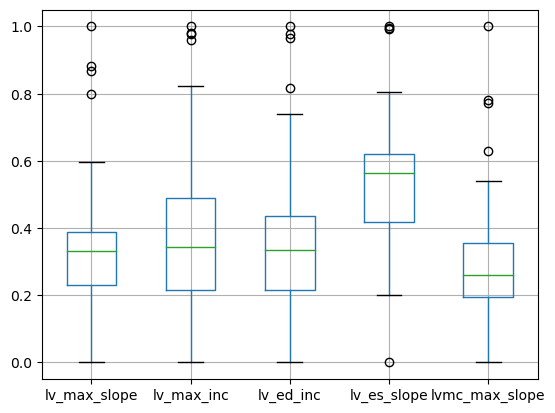

In [48]:
# boxplot for outlier features
fractals_3d_df_scaled.boxplot(column = list(outlier_features));

#### U test with 3d fractal features

In [49]:
# calculating p-value for 3D fractal features
u_test_fractals_3d_features, _, _ = u_test_func(fractals_3d_df, numerical_columns)

In [50]:
# looking at most discriminating fractal features
significant_feat = [ent for ent in u_test_fractals_3d_features if ent[1] < 0.2]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
lv_min_slope 0.107
lv_es_slope 0.145
lvmc_min_slope 0.145


In [51]:
# adding most important fractal features to the list 
important_features.extend([feat[0] for feat in significant_feat])

#### Correlation analysis with fractal features

In [52]:
# adding pkvo2 values to the fractals dataframe
pids = fractals_3d_df.patient_id.values
pkvo2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    
fractals_3d_df['pkvo2'] = pkvo2_vals

In [53]:
# looking at R^2 values of fractal features most correlated with PkVO2
response = pkvo2_vals
predictors = numerical_columns
r2_vals = []
for predictor in predictors:
    pearson_val = pearsonr(fractals_3d_df[predictor],response)
    r2_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],3)))
print('significant features:\n(feature name, R^2 values, p-value)')
significant_feat = [ent for ent in sorted(r2_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1]
[print(feat) for feat in significant_feat];

significant features:
(feature name, R^2 values, p-value)
('lvmc_min_inc', 0.168, 0.003)
('lv_min_inc', 0.108, 0.018)
('lvmc_min_slope', 0.101, 0.023)


In [54]:
# adding the above features to the list
important_features.extend([feat[0] for feat in significant_feat])
important_features = list(set(important_features))

## CCIPD morphology features

These 2D features look at properties such as compactness, convexity, etc of the LV at the slice level and computes the average and standard deviation across the slices.

In [55]:
# reading the morphology features file
ccipd_shape_2d_df = pd.read_excel('../shape_8.xlsx').T
ccipd_shape_2d_df.columns = ccipd_shape_2d_df.iloc[0]
ccipd_shape_2d_df = ccipd_shape_2d_df.iloc[1:]
ccipd_shape_2d_df['patient_id'] = ccipd_shape_2d_df.index.values
ccipd_shape_2d_df.reset_index(inplace=True, drop=True)
ccipd_shape_2d_df = ccipd_shape_2d_df.rename_axis(None, axis=1)
ccipd_shape_2d_df.head()

,Phase,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,...,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,patient_id
0,ed10,0.853717,0.056159,0.794044,0.09929,13.23571,0.296948,0.964794,0.00817,1.039296,...,4.629694,0.962437,0.006079,1.201052,0.07069,18.895799,3.929156,0.04572,0.022612,100B
1,es4,0.873973,0.026149,0.829406,0.049693,13.154499,0.411352,0.965983,0.007253,0.986385,...,6.340455,0.962548,0.005264,1.182248,0.047447,19.365184,3.923945,0.041816,0.014645,100B.1
2,ed0,0.864346,0.033201,0.824055,0.062689,12.844654,0.539633,0.971635,0.00612,0.924749,...,3.318184,0.963873,0.004567,1.122989,0.034393,17.623827,3.466032,0.041742,0.020314,101B
3,es4,0.866036,0.033473,0.885459,0.06968,12.15369,0.83334,0.9702,0.008287,0.762343,...,2.135214,0.963762,0.003952,0.991932,0.108874,15.200941,4.275771,0.056368,0.040442,101B.1
4,ed0,0.881539,0.03312,0.840172,0.055447,13.224271,0.285614,0.962707,0.008224,1.045217,...,2.777332,0.963431,0.004889,1.09891,0.068109,20.577368,3.58046,0.035157,0.009932,103


In [56]:
def extract_phase_shape_2d_df(shape_2d_df, phase):
    '''
    extracts ED and ES phases
    '''
    num_rows = shape_2d_df.shape[0]
    data = []
    columns = shape_2d_df.columns.values
    
    for i in range(num_rows):
        row_entries = shape_2d_df.iloc[i]
        if phase in row_entries['Phase']:
            row_values = list(row_entries.values)[:-1]
            patient_id = str(row_entries['patient_id']).split('.')[0]
            row_values.append(patient_id)
            data.append(row_values)
    df = pd.DataFrame(data=data, columns = columns)    
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns=['Phase'])
    return df

In [57]:
# extracting ED and ES phases
ed_shape_2d_df = extract_phase_shape_2d_df(ccipd_shape_2d_df, 'ed')
es_shape_2d_df = extract_phase_shape_2d_df(ccipd_shape_2d_df, 'es')

In [58]:
ed_shape_2d_df.head()

,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,lv_std_Hausdorff_Dimension,...,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,patient_id
0,0.853717,0.056159,0.794044,0.099290,13.235710,0.296948,0.964794,0.008170,1.039296,0.058331,...,4.629694,0.962437,0.006079,1.201052,0.070690,18.895799,3.929156,0.045720,0.022612,100B
1,0.864346,0.033201,0.824055,0.062689,12.844654,0.539633,0.971635,0.006120,0.924749,0.098095,...,3.318184,0.963873,0.004567,1.122989,0.034393,17.623827,3.466032,0.041742,0.020314,101B
2,0.881539,0.033120,0.840172,0.055447,13.224271,0.285614,0.962707,0.008224,1.045217,0.048148,...,2.777332,0.963431,0.004889,1.098910,0.068109,20.577368,3.580460,0.035157,0.009932,103
3,0.900517,0.022261,0.879287,0.034969,13.186463,0.221792,0.961618,0.003998,0.886882,0.038052,...,4.376389,0.959868,0.005119,1.085385,0.056422,21.303569,3.572931,0.037064,0.007721,105B
4,0.860081,0.029107,0.823982,0.062522,12.917694,0.950794,0.966809,0.011090,0.830377,0.093879,...,5.327416,0.960738,0.007502,1.042750,0.077333,18.227353,3.299459,0.051179,0.018721,109


In [59]:
es_shape_2d_df.head()

,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,lv_std_Hausdorff_Dimension,...,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,patient_id
0,0.873973,0.026149,0.829406,0.049693,13.154499,0.411352,0.965983,0.007253,0.986385,0.031940,...,6.340455,0.962548,0.005264,1.182248,0.047447,19.365184,3.923945,0.041816,0.014645,100B
1,0.866036,0.033473,0.885459,0.069680,12.153690,0.833340,0.970200,0.008287,0.762343,0.098977,...,2.135214,0.963762,0.003952,0.991932,0.108874,15.200941,4.275771,0.056368,0.040442,101B
2,0.838511,0.057375,0.783540,0.096788,13.043803,0.242789,0.967903,0.012234,0.960224,0.053215,...,2.699241,0.960596,0.006323,1.149487,0.061612,19.741974,3.869690,0.030357,0.008335,103
3,0.892210,0.021140,0.886150,0.029275,12.797967,0.339924,0.965981,0.006043,0.924672,0.095212,...,5.541146,0.959437,0.004638,1.072997,0.070093,19.823505,3.161310,0.039868,0.011257,105B
4,0.840034,0.033041,0.823809,0.075507,12.588092,0.898496,0.971693,0.013949,0.843758,0.110392,...,1.825295,0.963960,0.007132,1.010903,0.029561,16.606575,1.905929,0.043686,0.009673,109


In [126]:
def convert_str_to_float(df):
    '''
    converting feature values from string to float 
    '''
    df_columns = df.columns
    numerical_columns = df_columns.drop(['patient_id']).values
    num_rows = df.shape[0]
    data = []
    
    for i in range(num_rows):
        row_entries = []
        for col in numerical_columns:
            val = float(df.loc[i][col])
            row_entries.append(val)
        data.append(row_entries)
    new_df = pd.DataFrame(data=data, columns=numerical_columns)
    new_df['patient_id'] = df['patient_id'].values
    new_df.reset_index(inplace=True, drop=True)
    return new_df

In [127]:
# converting string values to floats
ed_shape_2d_df = convert_str_to_float(ed_shape_2d_df)
es_shape_2d_df = convert_str_to_float(es_shape_2d_df)

In [130]:
es_shape_2d_df.describe()

,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,lv_std_Hausdorff_Dimension,...,lvmc_avg_compactness,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.843626,0.044758,0.821139,0.071627,12.475987,0.910644,0.971920,0.011357,0.874602,0.092286,...,20.740232,4.488978,0.963907,0.009865,1.096445,0.084122,16.560520,3.871840,0.045134,0.015913
std,0.021622,0.017512,0.040547,0.026837,0.513371,0.399620,0.005337,0.004223,0.070080,0.038908,...,3.300826,2.544319,0.007950,0.018017,0.059374,0.038399,2.524266,1.195093,0.007662,0.008354
min,0.795331,0.014854,0.749413,0.019306,10.971733,0.242789,0.956621,0.003442,0.663306,0.031940,...,15.848370,1.229996,0.909878,0.003936,0.991932,0.019445,11.937794,1.905929,0.030357,0.004509
25%,0.829414,0.033473,0.789129,0.052889,12.188905,0.652074,0.969461,0.008471,0.830050,0.064846,...,18.958461,3.112640,0.962821,0.005482,1.054040,0.049707,15.061590,2.966322,0.040434,0.009357
50%,0.843534,0.042093,0.823809,0.070128,12.570211,0.864271,0.971800,0.011092,0.875150,0.089172,...,20.254297,3.913042,0.963960,0.007217,1.083325,0.084542,16.166705,3.923945,0.044124,0.013431
75%,0.860116,0.054588,0.849429,0.088920,12.785561,1.160015,0.974569,0.013947,0.918807,0.109607,...,21.566637,5.381934,0.967283,0.009188,1.142304,0.108467,17.499242,4.492828,0.048285,0.020898
max,0.892210,0.108958,0.907986,0.135555,13.800228,2.261580,0.987050,0.030234,1.059094,0.205008,...,33.992499,17.490243,0.971742,0.142120,1.328175,0.169917,24.455107,6.957113,0.067629,0.040442


In [131]:
# saving ED & ES phases in csv format
ed_shape_2d_df.to_csv('ed_shape_2d.csv')
es_shape_2d_df.to_csv('es_shape_2d.csv')

In [62]:
ed_shape_2d_df = pd.read_csv('ed_shape_2d.csv')
ed_shape_2d_df.drop(columns=['Unnamed: 0'], inplace=True)
es_shape_2d_df = pd.read_csv('es_shape_2d.csv')
es_shape_2d_df.drop(columns=['Unnamed: 0'], inplace=True)

In [64]:
# dropping low LVEF patients
ed_shape_2d_df = ed_shape_2d_df[~ed_shape_2d_df['patient_id'].isin(low_lv_ef)]
es_shape_2d_df = es_shape_2d_df[~es_shape_2d_df['patient_id'].isin(low_lv_ef)]
ed_shape_2d_df.shape

(51, 29)

#### CCIPD morphology outliers

In [65]:
# looking at features with many outliers
ed_shape_2d_columns = ed_shape_2d_df.columns
numerical_columns = ed_shape_2d_columns.drop(['patient_id']).values
outlier_features = outlier_func(ed_shape_2d_df, numerical_columns, 4)
outlier_features

['lv_avg_area_overlap_ratio', 'lv_std_compactness']

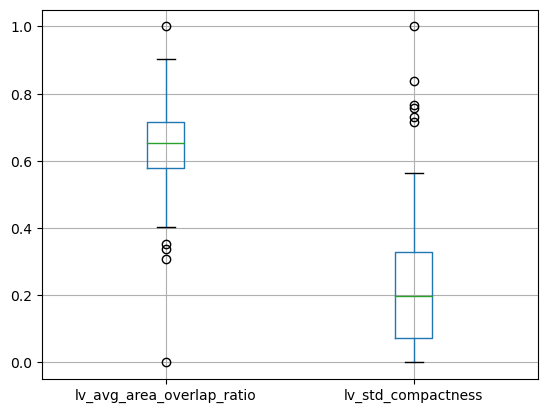

In [66]:
# box plot for outlier features
ed_shape_2d_df_scaled = ed_shape_2d_df.copy(deep=True)
ed_shape_2d_df_scaled[numerical_columns] = scaler.fit_transform(ed_shape_2d_df[numerical_columns])
ed_shape_2d_df_scaled.boxplot(column = list(outlier_features));

In [67]:
# looking at 'lv_avg_area_overlap_ratio' values
ed_shape_2d_df_scaled.sort_values(by=['lv_avg_area_overlap_ratio']).head()

,lv_avg_average_radial_ratio,lv_std_average_radial_ratio,lv_avg_area_overlap_ratio,lv_std_area_overlap_ratio,lv_avg_compactness,lv_std_compactness,lv_avg_convexity,lv_std_convexity,lv_avg_Hausdorff_Dimension,lv_std_Hausdorff_Dimension,...,lvmc_std_compactness,lvmc_avg_convexity,lvmc_std_convexity,lvmc_avg_Hausdorff_Dimension,lvmc_std_Hausdorff_Dimension,lvmc_avg_smoothness,lvmc_std_smoothness,lvmc_avg_std_distance_ratio,lvmc_std_std_distance_ratio,patient_id
39,0.000000,0.419758,0.000000,0.240181,1.000000,0.061702,0.013756,0.344102,0.543077,0.171274,...,0.257500,0.000000,0.339593,0.630654,0.417887,1.000000,0.899667,1.000000,0.237331,169
38,0.240138,0.647684,0.308206,0.640522,0.544784,0.328867,0.319908,0.614013,0.474150,0.152618,...,0.316901,0.419170,0.155785,0.833698,0.230907,0.098980,0.041505,0.780258,0.452143,168
13,0.288151,0.928950,0.335980,0.648853,0.416581,0.114681,0.720908,0.161386,0.568896,0.375993,...,0.153823,0.387949,0.579469,0.371809,0.295646,0.343129,0.647811,0.287159,0.423774,129
23,0.254086,0.983256,0.352043,0.872388,0.684492,0.375746,0.216028,0.294951,1.000000,0.306833,...,0.031167,0.440944,0.097000,0.660436,0.441796,0.088483,0.175537,0.824838,1.000000,146
32,0.440857,0.224977,0.404182,0.140852,0.570746,0.041536,0.243558,0.229361,0.000000,0.000000,...,0.078113,0.433002,0.439064,0.223844,0.035933,0.239725,0.000000,0.675402,0.307037,159


### U test with morphology features

In [68]:
# performing u test for ED data
u_test_ed_shape_2d_features, _, _ = u_test_func(ed_shape_2d_df, numerical_columns)

In [69]:
# looking at most discriminating features
significant_feat = [ent for ent in u_test_ed_shape_2d_features if ent[1] < 0.1]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
lv_std_compactness 0.078


In [70]:
# adding the feature to list of important features
important_features.extend([feat[0] for feat in significant_feat])

In [71]:
# u test for ES features
u_test_es_shape_2d_features, _, _ = u_test_func(es_shape_2d_df, numerical_columns)
significant_feat = [ent for ent in u_test_es_shape_2d_features if ent[1] < 0.15]
print('significant features: (feature name, p-value)')
[print(ent[0], round(ent[1],3)) for ent in sorted(significant_feat, key = lambda x: x[1])];

significant features: (feature name, p-value)
lv_std_average_radial_ratio 0.103
lv_std_std_distance_ratio 0.125


In [72]:
# adding discriminiating features to the list
important_features.extend([feat[0] for feat in significant_feat])

#### Correlation analysis with morphology features

In [73]:
# adding pkvo2 values to the morphology dataframe
pids = ed_shape_2d_df.patient_id.values
pkvo2_vals = []
for pid in pids:
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    pkvo2_vals.append(cpet_record['VO2 (MAX):'].values[0])
    
ed_shape_2d_df['pkvo2'] = pkvo2_vals
es_shape_2d_df['pkvo2'] = pkvo2_vals

/var/folders/99/3y_6msy17fl4qy16j55dfc4w0000gn/T/ipykernel_39238/136387369.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ed_shape_2d_df['pkvo2'] = pkvo2_vals


In [74]:
# looking at R^2 values of fractal features most correlated with PkVO2
response = pkvo2_vals
predictors = numerical_columns
ed_r2_vals = []
es_r2_vals = []
for predictor in predictors:
    pearson_val = pearsonr(ed_shape_2d_df[predictor],response)
    ed_r2_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],3)))
    pearson_val = pearsonr(es_shape_2d_df[predictor],response)
    es_r2_vals.append((predictor, round(pearson_val[0]**2,3), round(pearson_val[1],3)))
print('significant features:\n(feature name, R^2 values, p-value)')
significant_feat = [ent for ent in sorted(ed_r2_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1]
[print(feat) for feat in significant_feat];

significant features:
(feature name, R^2 values, p-value)


In [75]:
significant_feat = [ent for ent in sorted(es_r2_vals, key=lambda x: x[1], reverse=True) if ent[1] > 0.1]
[print(feat) for feat in significant_feat];

('lv_avg_average_radial_ratio', 0.176, 0.002)
('lv_avg_std_distance_ratio', 0.158, 0.004)
('lvmc_avg_average_radial_ratio', 0.116, 0.014)
('lvmc_avg_smoothness', 0.109, 0.018)


In [76]:
# adding the above features to the list
important_features.extend([feat[0] for feat in significant_feat])
important_features = list(set(important_features))

## Multivariate Analysis

Let's combine all features and predict PkVO2

In [77]:
# removing duplicate features
important_features = list(set(important_features))

In [181]:
def extract_important_columns(csv_file, important_features):
    '''
    selects important features from the csv file
    '''
    df = pd.read_csv(csv_file)
    df.drop(columns=['Unnamed: 0'],inplace=True)
    common_features = list(set(df.columns.values) & set(important_features))
    
    return df[['patient_id']+common_features]


In [183]:
# selecting important features from pyradiomics
pyrads_df_imp = extract_important_columns('../pyrads_3d.csv', important_features)
pyrads_df_imp.head()

,patient_id,ed_val_original_shape_MinorAxisLength,std_dev_original_shape_VoxelVolume,min_original_shape_SurfaceVolumeRatio,ed_val_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterRow,mean_original_shape_MajorAxisLength,mean_original_shape_Sphericity,max_original_shape_Maximum3DDiameter,min_original_shape_MajorAxisLength,...,es_val_original_shape_MeshVolume,mean_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterColumn,max_original_shape_Maximum2DDiameterColumn,snr_original_shape_SurfaceArea,max_original_shape_Maximum2DDiameterRow,ed_val_original_shape_Maximum2DDiameterColumn,median_original_shape_Maximum2DDiameterColumn,median_original_shape_Maximum2DDiameterRow,snr_original_shape_SurfaceVolumeRatio
0,100B,56.189551,8939.470270,0.109978,194762.320312,103.836007,94.769516,0.718340,107.764863,87.309548,...,163115.593750,182547.546875,101.683194,105.088356,37.728567,107.108590,102.396976,102.396976,106.076697,18.581358
1,101B,49.740365,30097.474262,0.129696,131872.171875,82.797960,74.694549,0.656805,93.939143,66.251094,...,38576.234375,83817.995313,78.651526,90.341366,4.081864,93.324116,90.341366,80.359646,86.032009,6.510198
2,103,61.196740,33476.877838,0.106657,201691.828125,98.243603,89.957593,0.743902,109.454400,86.169647,...,103322.148438,154255.300000,95.620363,98.924529,8.529581,104.254796,98.924529,95.926686,98.924529,8.775362
3,105B,59.891196,33533.562515,0.105672,224877.617188,102.779518,94.498109,0.744217,109.117268,84.664772,...,122068.765625,177489.598438,102.401246,107.108590,8.355850,108.182788,107.108590,104.144806,103.696041,12.575822
4,109,54.112955,41850.236628,0.124354,151871.007812,87.421812,79.522228,0.720003,103.601777,61.725231,...,41424.750000,94326.157366,86.846696,100.842777,3.305595,101.595091,98.894199,88.703157,88.703157,5.714275


In [184]:
# selecting important volume features 
vol_df_imp = extract_important_columns('../vol.csv', important_features)
vol_df_imp.head()

,patient_id,lvmc_vol_max,lv_std,lvmc_vol_ed,ejection_fraction,lvmc_vol_es,lv_snr,lv_vol_ed,lv_vol_es,lvmc_vol_min
0,100B,148709.4375,2168.140010,139436.2500,0.159945,122988.1875,20.616114,196361.4375,164954.4375,118114.6875
1,101B,136187.2500,9517.657049,123462.0000,0.701015,136187.2500,2.837491,133344.3750,39867.9375,96996.1875
2,103,175513.6875,10586.318292,144242.0625,0.483688,175513.6875,4.654657,203333.2500,104983.3125,144242.0625
3,105B,176055.1875,10604.243561,153582.9375,0.454600,156019.6875,5.340548,226617.7500,123597.3750,148777.1250
4,109,135239.6250,15817.902632,126507.9375,0.723423,111413.6250,2.284888,153447.5625,42440.0625,111413.6250


In [185]:
# merging pyradiomics and volume features
important_features_df = pd.merge(pyrads_df_imp, vol_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,ed_val_original_shape_MinorAxisLength,std_dev_original_shape_VoxelVolume,min_original_shape_SurfaceVolumeRatio,ed_val_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterRow,mean_original_shape_MajorAxisLength,mean_original_shape_Sphericity,max_original_shape_Maximum3DDiameter,min_original_shape_MajorAxisLength,...,snr_original_shape_SurfaceVolumeRatio,lvmc_vol_max,lv_std,lvmc_vol_ed,ejection_fraction,lvmc_vol_es,lv_snr,lv_vol_ed,lv_vol_es,lvmc_vol_min
0,100B,56.189551,8939.470270,0.109978,194762.320312,103.836007,94.769516,0.718340,107.764863,87.309548,...,18.581358,148709.4375,2168.140010,139436.2500,0.159945,122988.1875,20.616114,196361.4375,164954.4375,118114.6875
1,101B,49.740365,30097.474262,0.129696,131872.171875,82.797960,74.694549,0.656805,93.939143,66.251094,...,6.510198,136187.2500,9517.657049,123462.0000,0.701015,136187.2500,2.837491,133344.3750,39867.9375,96996.1875
2,103,61.196740,33476.877838,0.106657,201691.828125,98.243603,89.957593,0.743902,109.454400,86.169647,...,8.775362,175513.6875,10586.318292,144242.0625,0.483688,175513.6875,4.654657,203333.2500,104983.3125,144242.0625
3,105B,59.891196,33533.562515,0.105672,224877.617188,102.779518,94.498109,0.744217,109.117268,84.664772,...,12.575822,176055.1875,10604.243561,153582.9375,0.454600,156019.6875,5.340548,226617.7500,123597.3750,148777.1250
4,109,54.112955,41850.236628,0.124354,151871.007812,87.421812,79.522228,0.720003,103.601777,61.725231,...,5.714275,135239.6250,15817.902632,126507.9375,0.723423,111413.6250,2.284888,153447.5625,42440.0625,111413.6250


In [186]:
# selecting important 3d fractal features
fractals_3d_df_imp = extract_important_columns('../fractals_3d.csv', important_features)
fractals_3d_df_imp.head()

,patient_id,lv_es_slope,lvmc_min_inc,lv_min_inc,lv_min_slope,lvmc_min_slope
0,100B,2.494780,7.766741,7.874847,2.464594,2.255928
1,101B,2.006020,7.245306,6.224656,1.930682,2.030273
2,103,2.816428,8.137937,7.521387,2.816428,2.843704
3,105B,2.587199,7.784995,7.341483,2.343175,2.325445
4,109,2.048207,7.537170,6.216915,2.048207,2.335396


In [187]:
# merging fractal features
important_features_df = pd.merge(important_features_df, fractals_3d_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,ed_val_original_shape_MinorAxisLength,std_dev_original_shape_VoxelVolume,min_original_shape_SurfaceVolumeRatio,ed_val_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterRow,mean_original_shape_MajorAxisLength,mean_original_shape_Sphericity,max_original_shape_Maximum3DDiameter,min_original_shape_MajorAxisLength,...,lvmc_vol_es,lv_snr,lv_vol_ed,lv_vol_es,lvmc_vol_min,lv_es_slope,lvmc_min_inc,lv_min_inc,lv_min_slope,lvmc_min_slope
0,100B,56.189551,8939.470270,0.109978,194762.320312,103.836007,94.769516,0.718340,107.764863,87.309548,...,122988.1875,20.616114,196361.4375,164954.4375,118114.6875,2.494780,7.766741,7.874847,2.464594,2.255928
1,101B,49.740365,30097.474262,0.129696,131872.171875,82.797960,74.694549,0.656805,93.939143,66.251094,...,136187.2500,2.837491,133344.3750,39867.9375,96996.1875,2.006020,7.245306,6.224656,1.930682,2.030273
2,103,61.196740,33476.877838,0.106657,201691.828125,98.243603,89.957593,0.743902,109.454400,86.169647,...,175513.6875,4.654657,203333.2500,104983.3125,144242.0625,2.816428,8.137937,7.521387,2.816428,2.843704
3,105B,59.891196,33533.562515,0.105672,224877.617188,102.779518,94.498109,0.744217,109.117268,84.664772,...,156019.6875,5.340548,226617.7500,123597.3750,148777.1250,2.587199,7.784995,7.341483,2.343175,2.325445
4,109,54.112955,41850.236628,0.124354,151871.007812,87.421812,79.522228,0.720003,103.601777,61.725231,...,111413.6250,2.284888,153447.5625,42440.0625,111413.6250,2.048207,7.537170,6.216915,2.048207,2.335396


In [188]:
# selecting important 2d morphology features from ED phase
ed_shape_2d_df_imp = extract_important_columns('ed_shape_2d.csv', important_features)
ed_shape_2d_df_imp.head()

,patient_id,lv_avg_std_distance_ratio,lv_avg_average_radial_ratio,lv_std_compactness,lvmc_avg_average_radial_ratio,lvmc_avg_smoothness,lv_std_std_distance_ratio,lv_std_average_radial_ratio
0,100B,0.064303,0.853717,0.296948,0.901745,18.895799,0.025692,0.056159
1,101B,0.066299,0.864346,0.539633,0.920933,17.623827,0.021420,0.033201
2,103,0.056651,0.881539,0.285614,0.920739,20.577368,0.021518,0.033120
3,105B,0.048382,0.900517,0.221792,0.921480,21.303569,0.015523,0.022261
4,109,0.075774,0.860081,0.950794,0.892221,18.227353,0.021907,0.029107


In [189]:
# merging important 2d morphology features from ED phase
important_features_df = pd.merge(important_features_df, ed_shape_2d_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,ed_val_original_shape_MinorAxisLength,std_dev_original_shape_VoxelVolume,min_original_shape_SurfaceVolumeRatio,ed_val_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterRow,mean_original_shape_MajorAxisLength,mean_original_shape_Sphericity,max_original_shape_Maximum3DDiameter,min_original_shape_MajorAxisLength,...,lv_min_inc,lv_min_slope,lvmc_min_slope,lv_avg_std_distance_ratio,lv_avg_average_radial_ratio,lv_std_compactness,lvmc_avg_average_radial_ratio,lvmc_avg_smoothness,lv_std_std_distance_ratio,lv_std_average_radial_ratio
0,100B,56.189551,8939.470270,0.109978,194762.320312,103.836007,94.769516,0.718340,107.764863,87.309548,...,7.874847,2.464594,2.255928,0.064303,0.853717,0.296948,0.901745,18.895799,0.025692,0.056159
1,101B,49.740365,30097.474262,0.129696,131872.171875,82.797960,74.694549,0.656805,93.939143,66.251094,...,6.224656,1.930682,2.030273,0.066299,0.864346,0.539633,0.920933,17.623827,0.021420,0.033201
2,103,61.196740,33476.877838,0.106657,201691.828125,98.243603,89.957593,0.743902,109.454400,86.169647,...,7.521387,2.816428,2.843704,0.056651,0.881539,0.285614,0.920739,20.577368,0.021518,0.033120
3,105B,59.891196,33533.562515,0.105672,224877.617188,102.779518,94.498109,0.744217,109.117268,84.664772,...,7.341483,2.343175,2.325445,0.048382,0.900517,0.221792,0.921480,21.303569,0.015523,0.022261
4,109,54.112955,41850.236628,0.124354,151871.007812,87.421812,79.522228,0.720003,103.601777,61.725231,...,6.216915,2.048207,2.335396,0.075774,0.860081,0.950794,0.892221,18.227353,0.021907,0.029107


In [190]:
# selecting important 2d morphology features from ES phase
es_shape_2d_df_imp = extract_important_columns('es_shape_2d.csv', important_features)
es_shape_2d_df_imp.head()

,patient_id,lv_avg_std_distance_ratio,lv_avg_average_radial_ratio,lv_std_compactness,lvmc_avg_average_radial_ratio,lvmc_avg_smoothness,lv_std_std_distance_ratio,lv_std_average_radial_ratio
0,100B,0.065019,0.873973,0.411352,0.906873,19.365184,0.010946,0.026149
1,101B,0.072192,0.866036,0.833340,0.887405,15.200941,0.013599,0.033473
2,103,0.082624,0.838511,0.242789,0.938356,19.741974,0.041558,0.057375
3,105B,0.050001,0.892210,0.339924,0.919576,19.823505,0.011419,0.021140
4,109,0.088542,0.840034,0.898496,0.901940,16.606575,0.020674,0.033041


In [191]:
# merging important 2d morphology features from ED phase
important_features_df = pd.merge(important_features_df, es_shape_2d_df_imp, on="patient_id", how="left")
important_features_df.head()

,patient_id,ed_val_original_shape_MinorAxisLength,std_dev_original_shape_VoxelVolume,min_original_shape_SurfaceVolumeRatio,ed_val_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterRow,mean_original_shape_MajorAxisLength,mean_original_shape_Sphericity,max_original_shape_Maximum3DDiameter,min_original_shape_MajorAxisLength,...,lvmc_avg_smoothness_x,lv_std_std_distance_ratio_x,lv_std_average_radial_ratio_x,lv_avg_std_distance_ratio_y,lv_avg_average_radial_ratio_y,lv_std_compactness_y,lvmc_avg_average_radial_ratio_y,lvmc_avg_smoothness_y,lv_std_std_distance_ratio_y,lv_std_average_radial_ratio_y
0,100B,56.189551,8939.470270,0.109978,194762.320312,103.836007,94.769516,0.718340,107.764863,87.309548,...,18.895799,0.025692,0.056159,0.065019,0.873973,0.411352,0.906873,19.365184,0.010946,0.026149
1,101B,49.740365,30097.474262,0.129696,131872.171875,82.797960,74.694549,0.656805,93.939143,66.251094,...,17.623827,0.021420,0.033201,0.072192,0.866036,0.833340,0.887405,15.200941,0.013599,0.033473
2,103,61.196740,33476.877838,0.106657,201691.828125,98.243603,89.957593,0.743902,109.454400,86.169647,...,20.577368,0.021518,0.033120,0.082624,0.838511,0.242789,0.938356,19.741974,0.041558,0.057375
3,105B,59.891196,33533.562515,0.105672,224877.617188,102.779518,94.498109,0.744217,109.117268,84.664772,...,21.303569,0.015523,0.022261,0.050001,0.892210,0.339924,0.919576,19.823505,0.011419,0.021140
4,109,54.112955,41850.236628,0.124354,151871.007812,87.421812,79.522228,0.720003,103.601777,61.725231,...,18.227353,0.021907,0.029107,0.088542,0.840034,0.898496,0.901940,16.606575,0.020674,0.033041


In [192]:
# dropping low LVEF patients
important_features_df = important_features_df[~important_features_df['patient_id'].isin(low_lv_ef)].copy(deep=True)
important_features_df.shape

(51, 103)

In [194]:
# selecting numerical columns for scaling
important_features_columns = important_features_df.columns
numerical_columns = important_features_columns.drop(['patient_id']).values
important_features_df_scaled = important_features_df.copy(deep=True)
important_features_df_scaled[numerical_columns] = scaler.fit_transform(important_features_df[numerical_columns])

In [195]:
# adding PkVO2 values to the final data frame
vo2_max = []
num_rows = important_features_df.shape[0]
for n in range(num_rows):
    pid = important_features_df.iloc[n]['patient_id']
    num_pid = int(pid[0:3])
    cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
    vo2_max.append((pid,cpet_record['VO2 (MAX):'].values[0],\
                               cpet_record['dyspnea'].values[0]))
    
important_features_df['pkvo2'] = [ent[1] for ent in vo2_max]
important_features_df['dyspnea'] = [ent[2] for ent in vo2_max]

In [197]:
important_features_df.head()

,patient_id,ed_val_original_shape_MinorAxisLength,std_dev_original_shape_VoxelVolume,min_original_shape_SurfaceVolumeRatio,ed_val_original_shape_MeshVolume,mean_original_shape_Maximum2DDiameterRow,mean_original_shape_MajorAxisLength,mean_original_shape_Sphericity,max_original_shape_Maximum3DDiameter,min_original_shape_MajorAxisLength,...,lv_std_average_radial_ratio_x,lv_avg_std_distance_ratio_y,lv_avg_average_radial_ratio_y,lv_std_compactness_y,lvmc_avg_average_radial_ratio_y,lvmc_avg_smoothness_y,lv_std_std_distance_ratio_y,lv_std_average_radial_ratio_y,pkvo2,dyspnea
1,101B,49.740365,30097.474262,0.129696,131872.171875,82.797960,74.694549,0.656805,93.939143,66.251094,...,0.033201,0.072192,0.866036,0.833340,0.887405,15.200941,0.013599,0.033473,1.52,1.0
2,103,61.196740,33476.877838,0.106657,201691.828125,98.243603,89.957593,0.743902,109.454400,86.169647,...,0.033120,0.082624,0.838511,0.242789,0.938356,19.741974,0.041558,0.057375,2.36,1.0
3,105B,59.891196,33533.562515,0.105672,224877.617188,102.779518,94.498109,0.744217,109.117268,84.664772,...,0.022261,0.050001,0.892210,0.339924,0.919576,19.823505,0.011419,0.021140,2.53,1.0
4,109,54.112955,41850.236628,0.124354,151871.007812,87.421812,79.522228,0.720003,103.601777,61.725231,...,0.029107,0.088542,0.840034,0.898496,0.901940,16.606575,0.020674,0.033041,1.23,1.0
6,113B,47.723800,30486.301783,0.150528,107138.031250,91.277966,83.795321,0.644375,101.927670,77.215350,...,0.069127,0.085987,0.831353,1.464580,0.889883,13.102552,0.022662,0.045689,1.32,1.0


In [202]:
# saving the dataframe containing most important features in a csv file for final predictive model building
important_features_df.to_csv('vol_pyrads_3d_fractals_2d.csv')

### Appendix

#### Hierarchical clustering

In [167]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from matplotlib.pyplot import figure

In [168]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_font_size = 12, leaf_rotation = 0)
    return linkage_matrix

In [169]:
# making hierarchical clusters of patients
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
multivariate_x = important_features_df_scaled[max_reg_features]
model = model.fit(multivariate_x)

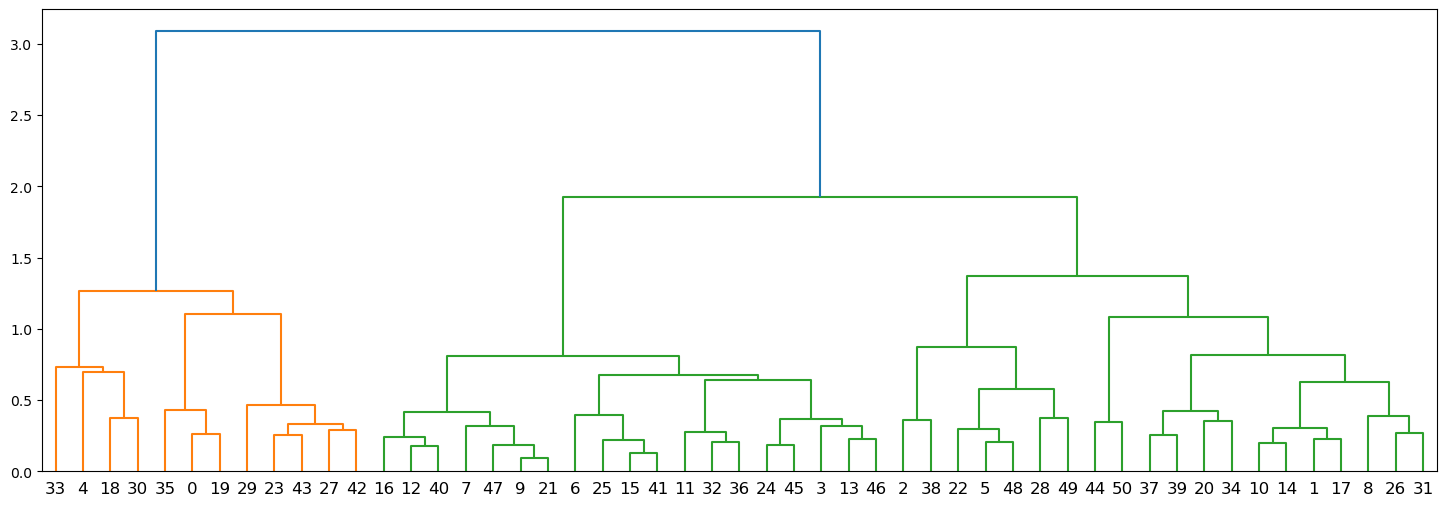

In [170]:
# looking at unsupervised clusters and dendograms in the data
figure(figsize=(18, 6))
linkage_matrix = plot_dendrogram(model)

In [171]:
# labeling patients with hierarchical clusters
clustering_model = AgglomerativeClustering(n_clusters=2)
clustering_model.fit(multivariate_x)
clustering_model.labels_

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0])

In [172]:
# separating out the indices of 2 clusters
cluster_0 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 0]
cluster_1 = [ind for ind, ent in enumerate(clustering_model.labels_) if ent == 1]

In [173]:
df = important_features_df_scaled.reset_index(drop=True)

In [174]:
# finding out the patient ids belonging to the 2 clusters
cluster_0_ids = df.loc[cluster_0].patient_id.values
cluster_1_ids = df.loc[cluster_1].patient_id.values

In [175]:
def cluster_condition(cluster):
    '''
    finds low/high pkvo2 condition for patients
    '''
    condition_arr = []
    for pid in cluster:
        num_pid = int(pid[0:3])
        cpet_record = cpet_data[cpet_data['Record ID'].values == num_pid]
        condition = cpet_record['dyspnea']
        if condition.values[0] == 1.:
            condition_arr.append((pid,1))
        else:
            condition_arr.append((pid,0))
    return condition_arr

In [176]:
# extracting low/high pkvo2 condition for patients
condition_arr_cluster_0 = cluster_condition(cluster_0_ids)
condition_arr_cluster_1 = cluster_condition(cluster_1_ids)

In [177]:
def count_high_low_vo2(condition_arr_cluster):
    '''
    returns the count of low/high pkvo2 patients
    '''
    count_0 = len([ent for ent in condition_arr_cluster if ent[1] == 0])
    count_1 = len([ent for ent in condition_arr_cluster if ent[1] == 1])
    
    return count_0, count_1

In [178]:
# counting the number of low/high pkvo2 patients
count_0_cluster_0, count_1_cluster_0 = count_high_low_vo2(condition_arr_cluster_0)
count_0_cluster_1, count_1_cluster_1 = count_high_low_vo2(condition_arr_cluster_1)

In [179]:
# looking at the patient distribution in the 2 hierarchical clusters
print(f'Cluster 0: 0:{count_0_cluster_0},  1:{count_1_cluster_0}')
print(f'Cluster 1: 0:{count_0_cluster_1},  1:{count_1_cluster_1}')

Cluster 0: 0:14,  1:25
Cluster 1: 0:6,  1:6


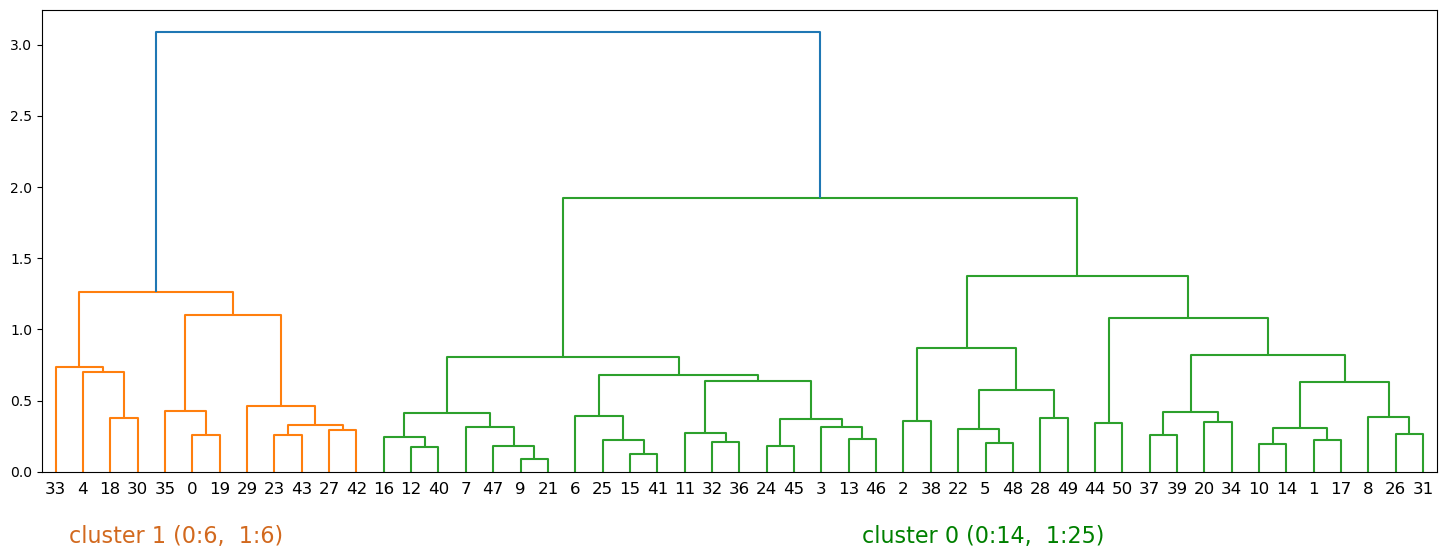

In [205]:
# looking at the clustering of patients with labels
figure(figsize=(18, 6))
linkage_matrix = plot_dendrogram(model)
y_pos = -0.5
plt.text(10,y_pos,f'cluster 1 (0:{count_0_cluster_1},  1:{count_1_cluster_1})',size=16, c='chocolate')
plt.text(300,y_pos,f'cluster 0 (0:{count_0_cluster_0},  1:{count_1_cluster_0})',size=16, c='green');

The above figure suggests that the 2 unsupervised clusters do not separate the high/low pkvo2 patients. This is especially true for cluster 1 where the split is half and half. For cluster 0, there is some separation: 64% of 39 patients are low pkvo2 patients.